<a href="https://colab.research.google.com/github/jplasserre/gdal/blob/master/Copia_de_(%2C)_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adaptado de: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

          Fecha  Cantidad
0    01/01/1959        35
1    02/01/1959        32
2    03/01/1959        30
3    04/01/1959        31
4    05/01/1959        44
..          ...       ...
360  27/12/1959        37
361  28/12/1959        52
362  29/12/1959        48
363  30/12/1959        55
364  31/12/1959        50

[365 rows x 2 columns]
(247, 12, 1) (247,) (106, 12, 1) (106,)
Epoch 1/1000
4/4 - 0s - loss: 0.2993 - val_loss: 0.2816
Epoch 2/1000
4/4 - 0s - loss: 0.1972 - val_loss: 0.1581
Epoch 3/1000
4/4 - 0s - loss: 0.1193 - val_loss: 0.1166
Epoch 4/1000
4/4 - 0s - loss: 0.1274 - val_loss: 0.1331
Epoch 5/1000
4/4 - 0s - loss: 0.1279 - val_loss: 0.1152
Epoch 6/1000
4/4 - 0s - loss: 0.1137 - val_loss: 0.1156
Epoch 7/1000
4/4 - 0s - loss: 0.1141 - val_loss: 0.1210
Epoch 8/1000
4/4 - 0s - loss: 0.1149 - val_loss: 0.1187
Epoch 9/1000
4/4 - 0s - loss: 0.1127 - val_loss: 0.1140
Epoch 10/1000
4/4 - 0s - loss: 0.1115 - val_loss: 0.1127
Epoch 11/1000
4/4 - 0s - loss: 0.1126 - val_loss: 0.1127
Epoch 

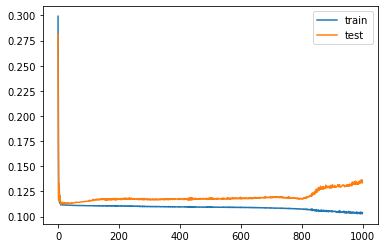

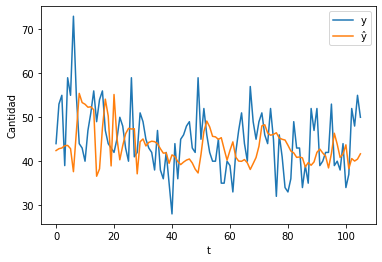

The Mean Squared Error of our Forecasts is 71.83999633789062
The Root Mean Squared Error od our Forecasts is 8.479999542236328


In [ ]:
#Importar librerías


from numpy import concatenate
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


#Definir series de supervisión (Convertir las series de tiempo en aprendizaje supervisado)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#Importar datos csv

df=pd.read_csv('NACIMIENTOS.csv',encoding='ISO-8859-1' ,sep=',') #Codificado en alfabeto latino con separador ;
print(df)
df.drop(['Fecha'],axis=1,inplace=True)

#Definir valores y dividir datos

values = df.values
values = values.astype('float32') #Formato de precisión
scaler = MinMaxScaler(feature_range=(0, 1)) #Escalar los valores
scaled = scaler.fit_transform(values)
df = series_to_supervised(scaled, 12, 1)
values = df.values
n_train_hours =int(len(values)*0.7)  #Entrenar con el 70% de los datos
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#MODELO LSTM

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1],1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

yhat=model.predict(test_X)
yhat=scaler.inverse_transform(yhat)
yhat=np.ravel(yhat)
yreal=scaler.inverse_transform(test_y.reshape(1,-1))
yreal=np.ravel(yreal)

#Gráficar error

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#Graficar pronóstico vs real

pyplot.plot(yreal,label='y')
pyplot.plot(yhat,label='\u0177')
pyplot.legend(loc='best')
pyplot.xlabel('t')
pyplot.ylabel('Cantidad')
pyplot.show()

mse=mean_squared_error(yreal, yhat)
print('The Mean Squared Error of our Forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error od our Forecasts is {}'.format(round(np.sqrt(mse), 2)))